# Traditional versus DL

In [13]:
import warnings
import os
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
from torchvision import models

In [118]:
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary, TTA_binary

In [122]:
from utils import save_model, load_model, lr_loss_plot

In [41]:
import random
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from datetime import datetime
from os import listdir
from os.path import join
import cv2
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook, tqdm
import ast
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import moment
from functools  import partial
import json
from sklearn.preprocessing import StandardScaler

In [16]:
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop 
from data_manipulation import balance_obs, multi_label_2_binary, DataBatches

In [9]:
PATH = Path("/data2/yinterian/ChestXray/")
PATH_IMGS =  PATH/"images_250/"
PATH_RADIOMIC = PATH/"radiomic_features"

## Numerical features creation

In [6]:
def read_image_gray(path):
    im = cv2.imread(str(path)).astype(np.uint8)
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

def GLCM_features(im):
    GLCM = greycomatrix(im,[1,2,4,6], [0, np.pi/4, np.pi/2])
    properties = ['contrast','dissimilarity','homogeneity','ASM', 'energy', 'correlation']
    GLCM_features= [greycoprops(GLCM, prop) for prop in properties]
    return np.concatenate(GLCM_features).flatten()

def statistical_features(im):
    stat_feat1 = [np.mean(im),np.std(im)]
    stat_feat2 = [moment(im,moment=i,axis=None) for i in range(2,6)]
    return np.array(stat_feat1+stat_feat2)

def entropy(im):
        '''
        From https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        signal = im.flatten()
        symset=list(set(signal))
        lensig=float(signal.size)
        propab=[np.size(signal[signal==i])/lensig for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return np.array([ent])

In [7]:
def extract_features(im):
    features = [GLCM_features, statistical_features, entropy]
    return np.concatenate([feature(im) for feature in features])

In [8]:
def read_extract(im_path):
    im = read_image_gray(im_path)
    return extract_features(im)

def labels2array(x):
    return np.array(x.split(' ')).astype(int)

def read_img2features(df, base_path):
    '''Reads  all the images under base_path/ImageIndex and extracts their features. 
    
    :param df: df with columns ImageIndex and Labels.
    :param base_path: base path such that base_path/ImageIndex is the location of the image.
    :return: X - numerical features, Y - labels
    '''
    X = np.array([read_extract(base_path/row) for row in tqdm_notebook(df.ImageIndex)])
    Y = df.Label.values
    try: Y = np.array(list(map(labels2array, Y))) # 14 labels
    except: Y = Y.astype(int) # 1 label
    return X,Y

In [91]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

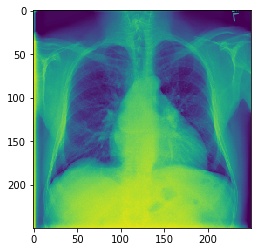

In [74]:
im = read_image_gray(str(PATH_IMGS/train_df.ImageIndex[0]))
plt.imshow(im)

## Dataset for Henia

In [92]:
DISEASE = 'Hernia'

In [93]:
idx2tgt = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
           'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
           'Pleural_Thickening', 'Hernia']

tgt2idx = {disease: i for i, disease in enumerate(idx2tgt)}

In [177]:
def get_train_val_test_disease(DISEASE):
    train_df = pd.read_csv(PATH/"train_df.csv")
    valid_df = pd.read_csv(PATH/"val_df.csv")
    test_df = pd.read_csv(PATH/"test_df.csv")
    
    train_df = multi_label_2_binary(train_df, tgt2idx[DISEASE])
    sample_train_df = balance_obs(train_df, amt=2000)

    valid_df = multi_label_2_binary(valid_df, tgt2idx[DISEASE])
    valid_df = balance_obs(valid_df, amt=2*len(valid_df[valid_df['Label']==1]))

    test_df = multi_label_2_binary(test_df, tgt2idx[DISEASE])
    test_df = balance_obs(test_df, amt=2*len(test_df[test_df['Label']==1]))
    
    train_df = sample_train_df.sample(frac=1, random_state=0).reset_index(drop=True)
    
    return train_df, valid_df, test_df

In [181]:
def compute_features(train_df, valid_df, test_df):
    X_train, Y_train = read_img2features(train_df, base_path=PATH_IMGS)
    X_valid, Y_valid = read_img2features(valid_df, base_path=PATH_IMGS)
    X_test, Y_test = read_img2features(test_df, base_path=PATH_IMGS)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [182]:
def save_features(DISEASE, X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    np.save(PATH_RADIOMIC/f'X_train_{DISEASE}', X_train)
    np.save(PATH_RADIOMIC/f'Y_train_{DISEASE}', Y_train)

    np.save(PATH_RADIOMIC/f'X_valid_{DISEASE}', X_valid)
    np.save(PATH_RADIOMIC/f'Y_valid', Y_valid)

    np.save(PATH_RADIOMIC/f'X_test_{DISEASE}', X_test)
    np.save(PATH_RADIOMIC/f'Y_test_{DISEASE}', Y_test)

In [98]:
# run just once
#save_features()

In [99]:
## load
X_train = np.load(PATH_RADIOMIC/'X_train.npy')
Y_train = np.load(PATH_RADIOMIC/'Y_train.npy')

X_valid = np.load(PATH_RADIOMIC/'X_valid.npy')
Y_valid = np.load(PATH_RADIOMIC/'Y_valid.npy')

X_test = np.load(PATH_RADIOMIC/'X_test.npy')
Y_test = np.load(PATH_RADIOMIC/'Y_test.npy')

In [100]:
scaler = StandardScaler()
train_X_tr = scaler.fit_transform(X_train)
test_X_tr = scaler.transform(X_test)

In [101]:
from sklearn.linear_model import LogisticRegressionCV


clf = LogisticRegressionCV(cv=5, random_state=0, penalty='l2',scoring='roc_auc',n_jobs=4
                          ).fit(train_X_tr, Y_train)
clf.score(test_X_tr, Y_test)

/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.6881535011915281

## dataset for 'Emphysema'

In [178]:
DISEASE = 'Emphysema'

In [179]:
train_df, valid_df, test_df = get_train_val_test_disease(DISEASE)

In [183]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = compute_features(train_df, valid_df, test_df)

In [184]:
save_features(DISEASE, X_train, Y_train, X_valid, Y_valid, X_test, Y_test)

## Experiments for all samples

In [185]:
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800,2000]

In [186]:
auc_scores_emp = []
for n in n_samples:
    x_train = X_train[:n].copy()
    y_train = Y_train[:n].copy()
    x_test = X_test.copy()
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    clf = LogisticRegressionCV(cv=5, random_state=0, penalty='l2',scoring='roc_auc',n_jobs=4)
    clf.fit(x_train, y_train)
    score = clf.score(x_test, Y_test)
    print(n, score)
    auc_scores_emp.append(score)

/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


50 0.5136973170258556


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


100 0.518241513608483


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


200 0.5727407427654454


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


400 0.5889521735647723


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


600 0.5979035195315036


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


800 0.5935491390133133


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


1000 0.5744711060088553


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


1200 0.5797324276829267


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


1400 0.5791656369145171


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


1600 0.5752763057541981


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


1800 0.578821310573628
2000 0.5800046239193297


/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yinterian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


In [104]:
auc_scores

[0.6129703015604265,
 0.5545994389082294,
 0.614280172762761,
 0.6367463717356181,
 0.6770023478557776,
 0.6727222806937263,
 0.6808265015540904,
 0.6840819602307727,
 0.6842513437690301,
 0.6845547698080532,
 0.6894287353611016,
 0.6881535011915281]

In [188]:
auc_scores_emp

[0.5136973170258556,
 0.518241513608483,
 0.5727407427654454,
 0.5889521735647723,
 0.5979035195315036,
 0.5935491390133133,
 0.5744711060088553,
 0.5797324276829267,
 0.5791656369145171,
 0.5752763057541981,
 0.578821310573628,
 0.5800046239193297]

In [105]:
train_df

,ImageIndex,Label
0,00010864_011.png,1
1,00014457_000.png,0
2,00013282_002.png,0
3,00020286_017.png,1
4,00011104_006.png,0
...,...,...
1995,00014653_001.png,1
1996,00001027_001.png,0
1997,00004458_004.png,0
1998,00008232_017.png,1


## deep learning training

In [189]:
SEED = 42
R_PIX = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 30
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=R_PIX)]

In [190]:
def create_optimizer(model, lr):
    params = [{'params': model.parameters(), 'lr': lr}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [196]:
def train(n_epochs, train_dl, valid_dl, model, lr=.01, wd=0, save_path=None,
          unfreeze=False):

    best_loss = np.inf
    prev_val_loss = np.inf
    cnt = 0
    total_iter = n_epochs*len(train_dl)
    if unfreeze:
        if cnt == 3: model.unfreeze(1)
        if cnt == 6: model.unfreeze(0)
    optimizer = create_optimizer(model, lr)
    
    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out.squeeze(), target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1

        cur_loss = agg_loss/agg_div
        
        val_loss, val_auc, _ = validate_binary(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {cur_loss} -  val loss {val_loss:.4f} AUC {val_auc:.4f}')

        if epoch == 10 or epoch == 20:
            lr /= 10
            print(lr)
        
        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

In [113]:
DATA = 'Pneumonia'

In [221]:
DISEASE = 'Hernia'
DISEASE = 'Emphysema'
train_df, valid_df, test_df = get_train_val_test_disease(DISEASE)

In [222]:
imagenet = {'loss': [],
           'auc': [],
           'accuracy': []}

no_pretrained = {'loss': [],
                 'auc': [],
                 'accuracy': []}

for n in n_samples:
    print(n)
    train_df_n = train_df[:n].copy()
    
    train_dl = DataBatches(df=train_df_n, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                           img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=False, seed=SEED)

    test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                          r_pix=R_PIX, normalize=False, seed=SEED)
    
    
    model = DenseNet121(1, pretrained=False, freeze=False).cuda()
    model_p = PATH/f'models/best_{DISEASE.lower()}_{n}_no_pretrained.pth'
    
    train(EPOCHS, train_dl, valid_dl, model, lr=.001, save_path=model_p)
    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    no_pretrained['auc'].append(auc)
    
    
    train_dl = DataBatches(df=train_df_n, transforms=TRANSFORMATIONS, shuffle=True,
                           img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=True, seed=SEED)

    valid_dl = DataBatches(df=valid_df, transforms=None, shuffle=False,
                           img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                           r_pix=R_PIX, normalize=True, seed=SEED)

    test_dl = DataBatches(df=test_df, transforms=TRANSFORMATIONS, shuffle=False,
                          img_folder_path=PATH_IMGS, batch_size=BATCH_SIZE, data=DATA,
                          r_pix=R_PIX, normalize=True, seed=SEED)
    
    model = DenseNet121(1, pretrained=True, freeze=True).cuda()
    model_p = PATH/f'models/best_{DISEASE.lower()}_{n}_imagenet.pth'
    
    
    train(EPOCHS, train_dl, valid_dl, model, lr=.001, save_path=model_p, unfreeze=True)
    print('Testing with TTA ....')
    load_model(model, model_p)
    loss, auc, accuracy = TTA_binary(model, test_dl)
    imagenet['auc'].append(auc)

50


/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7024967551231385 -  val loss 0.6992 AUC 0.5362
Ep. 2 - train loss 0.7490366840362549 -  val loss 1.9687 AUC 0.5515
Ep. 3 - train loss 0.686780436038971 -  val loss 3.6743 AUC 0.5464
Ep. 4 - train loss 0.6518328428268433 -  val loss 0.7937 AUC 0.4902
Ep. 5 - train loss 0.5867526829242706 -  val loss 2.2539 AUC 0.4534
Ep. 6 - train loss 0.5678894019126892 -  val loss 1.4243 AUC 0.4549
Ep. 7 - train loss 0.578804794549942 -  val loss 0.9487 AUC 0.4990
Ep. 8 - train loss 0.521577525138855 -  val loss 1.2805 AUC 0.5006
Ep. 9 - train loss 0.516569299697876 -  val loss 1.4360 AUC 0.4847
Ep. 10 - train loss 0.6352742862701416 -  val loss 2.0055 AUC 0.4718
Ep. 11 - train loss 0.5604870545864106 -  val loss 0.8385 AUC 0.5054
0.0001
Ep. 12 - train loss 0.5061087226867675 -  val loss 0.7809 AUC 0.5274
Ep. 13 - train loss 0.4474570381641388 -  val loss 0.7714 AUC 0.5422
Ep. 14 - train loss 0.4732351779937744 -  val loss 0.8854 AUC 0.5474
Ep. 15 - train loss 0.45506730794906614 

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7021488380432129 -  val loss 0.7212 AUC 0.4693
Ep. 2 - train loss 0.6784030771255494 -  val loss 0.7141 AUC 0.4690
Ep. 3 - train loss 0.6418201613426209 -  val loss 0.7126 AUC 0.4716
Ep. 4 - train loss 0.6859702777862549 -  val loss 0.7219 AUC 0.4782
Ep. 5 - train loss 0.6426632380485535 -  val loss 0.7053 AUC 0.4961
Ep. 6 - train loss 0.629345977306366 -  val loss 0.7077 AUC 0.5149
Ep. 7 - train loss 0.6381368553638458 -  val loss 0.7245 AUC 0.5226
Ep. 8 - train loss 0.6319506359100342 -  val loss 0.7355 AUC 0.5212
Ep. 9 - train loss 0.6064435505867004 -  val loss 0.7035 AUC 0.5124
Ep. 10 - train loss 0.6161869859695435 -  val loss 0.6992 AUC 0.5056
Ep. 11 - train loss 0.6211701202392578 -  val loss 0.6988 AUC 0.5139
0.0001
Ep. 12 - train loss 0.6118900775909424 -  val loss 0.7552 AUC 0.5251
Ep. 13 - train loss 0.5970534181594849 -  val loss 0.8224 AUC 0.5357
Ep. 14 - train loss 0.6085448241233826 -  val loss 0.7866 AUC 0.5327
Ep. 15 - train loss 0.596940641403198

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7983973121643066 -  val loss 1.1209 AUC 0.5494
Ep. 2 - train loss 0.7398465538024902 -  val loss 0.7456 AUC 0.4587
Ep. 3 - train loss 0.7253434586524964 -  val loss 0.7547 AUC 0.4622
Ep. 4 - train loss 0.6936364197731018 -  val loss 0.7747 AUC 0.4802
Ep. 5 - train loss 0.6885511016845703 -  val loss 0.9982 AUC 0.4785
Ep. 6 - train loss 0.6691196060180664 -  val loss 0.8572 AUC 0.4983
Ep. 7 - train loss 0.6252754831314087 -  val loss 0.8875 AUC 0.5021
Ep. 8 - train loss 0.6648286724090576 -  val loss 0.9361 AUC 0.4924
Ep. 9 - train loss 0.647077898979187 -  val loss 1.1843 AUC 0.5048
Ep. 10 - train loss 0.6542340850830078 -  val loss 0.7342 AUC 0.4985
Ep. 11 - train loss 0.6841703081130981 -  val loss 0.7451 AUC 0.4942
0.0001
Ep. 12 - train loss 0.6547032022476196 -  val loss 0.7322 AUC 0.4806
Ep. 13 - train loss 0.6268645715713501 -  val loss 0.7798 AUC 0.4905
Ep. 14 - train loss 0.5736645531654357 -  val loss 0.8680 AUC 0.5101
Ep. 15 - train loss 0.583219072818756

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7359834456443787 -  val loss 0.6903 AUC 0.5691
Ep. 2 - train loss 0.7558527231216431 -  val loss 0.7029 AUC 0.5687
Ep. 3 - train loss 0.6965192699432373 -  val loss 0.7019 AUC 0.5844
Ep. 4 - train loss 0.6784628582000732 -  val loss 0.7078 AUC 0.5968
Ep. 5 - train loss 0.704140727519989 -  val loss 0.6932 AUC 0.5954
Ep. 6 - train loss 0.6622450876235962 -  val loss 0.6855 AUC 0.5846
Ep. 7 - train loss 0.6598953700065613 -  val loss 0.6874 AUC 0.5761
Ep. 8 - train loss 0.6684593105316162 -  val loss 0.6841 AUC 0.5764
Ep. 9 - train loss 0.6412746524810791 -  val loss 0.6963 AUC 0.5870
Ep. 10 - train loss 0.6246708750724792 -  val loss 0.6860 AUC 0.5889
Ep. 11 - train loss 0.6240593004226684 -  val loss 0.6809 AUC 0.5883
0.0001
Ep. 12 - train loss 0.6344709920883179 -  val loss 0.6839 AUC 0.5880
Ep. 13 - train loss 0.6232973361015319 -  val loss 0.6855 AUC 0.5911
Ep. 14 - train loss 0.6071640658378601 -  val loss 0.7171 AUC 0.5983
Ep. 15 - train loss 0.599423151016235

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7559225392341614 -  val loss 9.7261 AUC 0.4558
Ep. 2 - train loss 0.7379764270782471 -  val loss 1.3905 AUC 0.5292
Ep. 3 - train loss 0.7265255999565124 -  val loss 4.4331 AUC 0.4568
Ep. 4 - train loss 0.7159423637390137 -  val loss 1.1252 AUC 0.5506
Ep. 5 - train loss 0.7087519073486328 -  val loss 0.7585 AUC 0.5390
Ep. 6 - train loss 0.6864605951309204 -  val loss 0.7278 AUC 0.4977
Ep. 7 - train loss 0.6783107900619507 -  val loss 0.7137 AUC 0.5026
Ep. 8 - train loss 0.6702906131744385 -  val loss 0.7285 AUC 0.4774
Ep. 9 - train loss 0.6844735240936279 -  val loss 0.7125 AUC 0.5173
Ep. 10 - train loss 0.6993418073654175 -  val loss 0.7473 AUC 0.5399
Ep. 11 - train loss 0.6963262605667114 -  val loss 0.8520 AUC 0.5404
0.0001
Ep. 12 - train loss 0.68926185131073 -  val loss 0.8046 AUC 0.5321
Ep. 13 - train loss 0.6829959440231324 -  val loss 0.7917 AUC 0.5158
Ep. 14 - train loss 0.6683795523643493 -  val loss 0.7689 AUC 0.5053
Ep. 15 - train loss 0.69175226688385 -

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.712401704788208 -  val loss 0.7519 AUC 0.5081
Ep. 2 - train loss 0.7003322267532348 -  val loss 0.6925 AUC 0.5460
Ep. 3 - train loss 0.7104804921150207 -  val loss 0.6897 AUC 0.5520
Ep. 4 - train loss 0.6838359498977661 -  val loss 0.6929 AUC 0.5652
Ep. 5 - train loss 0.6938458490371704 -  val loss 0.6926 AUC 0.5814
Ep. 6 - train loss 0.6743931913375855 -  val loss 0.6916 AUC 0.5826
Ep. 7 - train loss 0.6702498674392701 -  val loss 0.6848 AUC 0.5867
Ep. 8 - train loss 0.6589914894104004 -  val loss 0.6864 AUC 0.5804
Ep. 9 - train loss 0.6506732034683228 -  val loss 0.6875 AUC 0.5889
Ep. 10 - train loss 0.6515821266174316 -  val loss 0.7021 AUC 0.5837
Ep. 11 - train loss 0.6524319982528687 -  val loss 0.6822 AUC 0.5922
0.0001
Ep. 12 - train loss 0.6407164525985718 -  val loss 0.6835 AUC 0.5906
Ep. 13 - train loss 0.6249162745475769 -  val loss 0.6821 AUC 0.5948
Ep. 14 - train loss 0.6253907251358032 -  val loss 0.6826 AUC 0.5934
Ep. 15 - train loss 0.628728237152099

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7232200837135315 -  val loss 1.9590 AUC 0.5394
Ep. 2 - train loss 0.712415874004364 -  val loss 0.8909 AUC 0.5189
Ep. 3 - train loss 0.694366672039032 -  val loss 0.6948 AUC 0.5191
Ep. 4 - train loss 0.6969767212867737 -  val loss 0.7095 AUC 0.4840
Ep. 5 - train loss 0.6999328923225403 -  val loss 0.7048 AUC 0.4981
Ep. 6 - train loss 0.6995003843307495 -  val loss 0.7955 AUC 0.4645
Ep. 7 - train loss 0.706855502128601 -  val loss 0.7087 AUC 0.5218
Ep. 8 - train loss 0.6911099529266358 -  val loss 0.7413 AUC 0.4834
Ep. 9 - train loss 0.6837512445449829 -  val loss 0.9095 AUC 0.4549
Ep. 10 - train loss 0.6798314285278321 -  val loss 0.7533 AUC 0.4987
Ep. 11 - train loss 0.6897685766220093 -  val loss 0.7317 AUC 0.5088
0.0001
Ep. 12 - train loss 0.6787743330001831 -  val loss 1.3260 AUC 0.5188
Ep. 13 - train loss 0.6795942401885986 -  val loss 1.1461 AUC 0.4862
Ep. 14 - train loss 0.670674033164978 -  val loss 1.0468 AUC 0.4871
Ep. 15 - train loss 0.6735924482345581 -

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.704789445400238 -  val loss 0.6988 AUC 0.5303
Ep. 2 - train loss 0.6893843746185303 -  val loss 0.6903 AUC 0.5581
Ep. 3 - train loss 0.6635678553581238 -  val loss 0.6891 AUC 0.5732
Ep. 4 - train loss 0.6573958206176758 -  val loss 0.6868 AUC 0.5782
Ep. 5 - train loss 0.6401751184463501 -  val loss 0.6903 AUC 0.5785
Ep. 6 - train loss 0.65184091091156 -  val loss 0.6895 AUC 0.5851
Ep. 7 - train loss 0.6271469855308532 -  val loss 0.7170 AUC 0.5910
Ep. 8 - train loss 0.6296158146858215 -  val loss 0.7216 AUC 0.5962
Ep. 9 - train loss 0.6171808171272278 -  val loss 0.6909 AUC 0.5945
Ep. 10 - train loss 0.6047292554378509 -  val loss 0.7341 AUC 0.6008
Ep. 11 - train loss 0.6154408752918243 -  val loss 0.6898 AUC 0.5954
0.0001
Ep. 12 - train loss 0.5863949346542359 -  val loss 0.6899 AUC 0.5980
Ep. 13 - train loss 0.6221416974067688 -  val loss 0.7154 AUC 0.6024
Ep. 14 - train loss 0.5861243569850921 -  val loss 0.7224 AUC 0.6020
Ep. 15 - train loss 0.5801661479473114 

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7186477875709534 -  val loss 1.2828 AUC 0.4455
Ep. 2 - train loss 0.718191876411438 -  val loss 0.6983 AUC 0.5512
Ep. 3 - train loss 0.7047239557902019 -  val loss 0.6999 AUC 0.5441
Ep. 4 - train loss 0.6950568874677022 -  val loss 0.7006 AUC 0.4829
Ep. 5 - train loss 0.6924280261993409 -  val loss 0.8661 AUC 0.4768
Ep. 6 - train loss 0.6937399514516195 -  val loss 0.7004 AUC 0.5243
Ep. 7 - train loss 0.6862521704037984 -  val loss 0.7163 AUC 0.5194
Ep. 8 - train loss 0.6818753790855407 -  val loss 0.6993 AUC 0.5155
Ep. 9 - train loss 0.6915487686793009 -  val loss 0.7331 AUC 0.5022
Ep. 10 - train loss 0.6888996537526448 -  val loss 1.0394 AUC 0.5289
Ep. 11 - train loss 0.6957304143905639 -  val loss 0.7013 AUC 0.5293
0.0001
Ep. 12 - train loss 0.6890210580825805 -  val loss 0.7028 AUC 0.4989
Ep. 13 - train loss 0.6905460707346598 -  val loss 0.7106 AUC 0.4767
Ep. 14 - train loss 0.6956552871068319 -  val loss 0.7097 AUC 0.4732
Ep. 15 - train loss 0.689360879262288

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.724030810991923 -  val loss 0.7398 AUC 0.5713
Ep. 2 - train loss 0.6886113278071085 -  val loss 0.6923 AUC 0.5933
Ep. 3 - train loss 0.6552407956123352 -  val loss 0.7080 AUC 0.5985
Ep. 4 - train loss 0.6528561131159465 -  val loss 0.6771 AUC 0.5976
Ep. 5 - train loss 0.6309803009033204 -  val loss 0.6832 AUC 0.5980
Ep. 6 - train loss 0.6425620555877686 -  val loss 0.6851 AUC 0.6097
Ep. 7 - train loss 0.636209381421407 -  val loss 0.6747 AUC 0.6116
Ep. 8 - train loss 0.6260053849220276 -  val loss 0.6768 AUC 0.6095
Ep. 9 - train loss 0.6028630312283834 -  val loss 0.6787 AUC 0.6100
Ep. 10 - train loss 0.6080604473749797 -  val loss 0.7061 AUC 0.6132
Ep. 11 - train loss 0.6022737550735474 -  val loss 0.6892 AUC 0.6138
0.0001
Ep. 12 - train loss 0.6102710874875387 -  val loss 0.6839 AUC 0.6180
Ep. 13 - train loss 0.5974803392092387 -  val loss 0.6900 AUC 0.6170
Ep. 14 - train loss 0.6021371793746948 -  val loss 0.6945 AUC 0.6172
Ep. 15 - train loss 0.6021778718630473

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.733494371175766 -  val loss 0.7249 AUC 0.4652
Ep. 2 - train loss 0.7023958015441895 -  val loss 0.6922 AUC 0.5334
Ep. 3 - train loss 0.6942685127258301 -  val loss 0.7109 AUC 0.4944
Ep. 4 - train loss 0.6896795010566712 -  val loss 0.8863 AUC 0.5430
Ep. 5 - train loss 0.6937588906288147 -  val loss 2.5365 AUC 0.5527
Ep. 6 - train loss 0.6981979084014892 -  val loss 0.6923 AUC 0.5432
Ep. 7 - train loss 0.6949989461898803 -  val loss 0.7297 AUC 0.5427
Ep. 8 - train loss 0.6899014389514924 -  val loss 0.6997 AUC 0.5346
Ep. 9 - train loss 0.6941765749454498 -  val loss 0.7025 AUC 0.5388
Ep. 10 - train loss 0.6939464926719665 -  val loss 7.9005 AUC 0.4551
Ep. 11 - train loss 0.6871871590614319 -  val loss 0.7350 AUC 0.5342
0.0001
Ep. 12 - train loss 0.6963713181018829 -  val loss 0.7216 AUC 0.5324
Ep. 13 - train loss 0.6892737352848053 -  val loss 0.6976 AUC 0.5226
Ep. 14 - train loss 0.692932448387146 -  val loss 0.7061 AUC 0.4986
Ep. 15 - train loss 0.6970770418643951

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.6976534938812256 -  val loss 0.6993 AUC 0.5261
Ep. 2 - train loss 0.6892073464393615 -  val loss 0.7046 AUC 0.5667
Ep. 3 - train loss 0.666652489900589 -  val loss 0.6878 AUC 0.5708
Ep. 4 - train loss 0.6502537083625793 -  val loss 0.6891 AUC 0.5813
Ep. 5 - train loss 0.6503230834007263 -  val loss 0.6949 AUC 0.5885
Ep. 6 - train loss 0.6386858630180359 -  val loss 0.6955 AUC 0.5899
Ep. 7 - train loss 0.6297426033020019 -  val loss 0.6864 AUC 0.5964
Ep. 8 - train loss 0.6525019699335098 -  val loss 0.6886 AUC 0.5998
Ep. 9 - train loss 0.625435391664505 -  val loss 0.6985 AUC 0.5994
Ep. 10 - train loss 0.6057061171531677 -  val loss 0.6951 AUC 0.6038
Ep. 11 - train loss 0.6175111043453216 -  val loss 0.7046 AUC 0.6025
0.0001
Ep. 12 - train loss 0.6235984349250794 -  val loss 0.6951 AUC 0.6048
Ep. 13 - train loss 0.6105981820821762 -  val loss 0.6998 AUC 0.6044
Ep. 14 - train loss 0.6044753575325013 -  val loss 0.6937 AUC 0.6082
Ep. 15 - train loss 0.5905008697509766

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7198223915100098 -  val loss 0.6993 AUC 0.4751
Ep. 2 - train loss 0.6973237924575806 -  val loss 0.6947 AUC 0.5444
Ep. 3 - train loss 0.6973555326461792 -  val loss 0.6962 AUC 0.5365
Ep. 4 - train loss 0.6941499328613281 -  val loss 0.7570 AUC 0.5592
Ep. 5 - train loss 0.7038687887191772 -  val loss 0.7367 AUC 0.5434
Ep. 6 - train loss 0.6917181458473206 -  val loss 0.7000 AUC 0.5177
Ep. 7 - train loss 0.6988571534156799 -  val loss 0.7325 AUC 0.5170
Ep. 8 - train loss 0.7040121622085571 -  val loss 0.6944 AUC 0.5014
Ep. 9 - train loss 0.6923113298416138 -  val loss 0.6978 AUC 0.5228
Ep. 10 - train loss 0.6946661434173584 -  val loss 0.7143 AUC 0.5170
Ep. 11 - train loss 0.7018050136566162 -  val loss 0.7046 AUC 0.5335
0.0001
Ep. 12 - train loss 0.6936262092590332 -  val loss 1.1439 AUC 0.5342
Ep. 13 - train loss 0.6995230226516723 -  val loss 0.7127 AUC 0.5029
Ep. 14 - train loss 0.6946247873306275 -  val loss 0.6929 AUC 0.5193
Ep. 15 - train loss 0.69584836864471

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7011503829956055 -  val loss 0.6878 AUC 0.5691
Ep. 2 - train loss 0.6791483836174012 -  val loss 0.7014 AUC 0.5902
Ep. 3 - train loss 0.6598046655654908 -  val loss 0.6836 AUC 0.5982
Ep. 4 - train loss 0.649940191745758 -  val loss 0.6817 AUC 0.6085
Ep. 5 - train loss 0.6548957786560059 -  val loss 0.7294 AUC 0.6084
Ep. 6 - train loss 0.6398347816467285 -  val loss 0.6868 AUC 0.6112
Ep. 7 - train loss 0.6472306299209595 -  val loss 0.7140 AUC 0.6153
Ep. 8 - train loss 0.6310855622291565 -  val loss 0.7006 AUC 0.6131
Ep. 9 - train loss 0.6230157842636108 -  val loss 0.6864 AUC 0.6164
Ep. 10 - train loss 0.6333340520858765 -  val loss 0.7059 AUC 0.6218
Ep. 11 - train loss 0.6295183482170105 -  val loss 0.7323 AUC 0.6274
0.0001
Ep. 12 - train loss 0.6235851836204529 -  val loss 0.6864 AUC 0.6213
Ep. 13 - train loss 0.6224955444335938 -  val loss 0.6892 AUC 0.6250
Ep. 14 - train loss 0.6108699250221252 -  val loss 0.6874 AUC 0.6235
Ep. 15 - train loss 0.600805029869079

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7138099193572998 -  val loss 0.7029 AUC 0.5452
Ep. 2 - train loss 0.6953465024630229 -  val loss 0.6999 AUC 0.5038
Ep. 3 - train loss 0.6983537983894348 -  val loss 0.7272 AUC 0.5144
Ep. 4 - train loss 0.6923276305198669 -  val loss 0.7104 AUC 0.5206
Ep. 5 - train loss 0.6974827527999878 -  val loss 0.7004 AUC 0.5406
Ep. 6 - train loss 0.6891008607546488 -  val loss 0.7028 AUC 0.4512
Ep. 7 - train loss 0.6921177498499552 -  val loss 0.7835 AUC 0.5445
Ep. 8 - train loss 0.6929114611943563 -  val loss 0.6993 AUC 0.5367
Ep. 9 - train loss 0.6925670115152994 -  val loss 0.6960 AUC 0.5495
Ep. 10 - train loss 0.702794816493988 -  val loss 1.0041 AUC 0.4981
Ep. 11 - train loss 0.6970967149734497 -  val loss 0.6990 AUC 0.4908
0.0001
Ep. 12 - train loss 0.6941234413782755 -  val loss 0.6947 AUC 0.5179
Ep. 13 - train loss 0.6929855259259542 -  val loss 0.7018 AUC 0.5209
Ep. 14 - train loss 0.6900297562281291 -  val loss 0.6954 AUC 0.5149
Ep. 15 - train loss 0.69052978515625 

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.6976759060223897 -  val loss 0.6893 AUC 0.5635
Ep. 2 - train loss 0.6706556399663289 -  val loss 0.6834 AUC 0.5813
Ep. 3 - train loss 0.6568085424105327 -  val loss 0.6915 AUC 0.5964
Ep. 4 - train loss 0.6410479156176249 -  val loss 0.6817 AUC 0.6012
Ep. 5 - train loss 0.6457015895843505 -  val loss 0.6914 AUC 0.6056
Ep. 6 - train loss 0.6285800941785177 -  val loss 0.6908 AUC 0.6102
Ep. 7 - train loss 0.623929440577825 -  val loss 0.6817 AUC 0.6128
Ep. 8 - train loss 0.6203412934144338 -  val loss 0.6896 AUC 0.6114
Ep. 9 - train loss 0.6282230647404988 -  val loss 0.6870 AUC 0.6120
Ep. 10 - train loss 0.6163838628927867 -  val loss 0.7008 AUC 0.6096
Ep. 11 - train loss 0.6150661253929138 -  val loss 0.7122 AUC 0.6111
0.0001
Ep. 12 - train loss 0.6202372852961222 -  val loss 0.7451 AUC 0.6133
Ep. 13 - train loss 0.6120204611619313 -  val loss 0.6928 AUC 0.6142
Ep. 14 - train loss 0.5994237462679545 -  val loss 0.7750 AUC 0.6160
Ep. 15 - train loss 0.614650326569875

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7202100689070565 -  val loss 0.6893 AUC 0.5513
Ep. 2 - train loss 0.7047974126679557 -  val loss 0.6933 AUC 0.5556
Ep. 3 - train loss 0.7003759029933384 -  val loss 0.7170 AUC 0.5441
Ep. 4 - train loss 0.7016320371627808 -  val loss 0.7007 AUC 0.4907
Ep. 5 - train loss 0.6929745868274144 -  val loss 0.6995 AUC 0.4894
Ep. 6 - train loss 0.6916001735414777 -  val loss 0.7032 AUC 0.4701
Ep. 7 - train loss 0.69622202532632 -  val loss 0.6996 AUC 0.5188
Ep. 8 - train loss 0.6947423580714635 -  val loss 0.7766 AUC 0.4565
Ep. 9 - train loss 0.693534619808197 -  val loss 0.7341 AUC 0.5500
Ep. 10 - train loss 0.690912869317191 -  val loss 0.7033 AUC 0.5230
Ep. 11 - train loss 0.697348380770002 -  val loss 0.6960 AUC 0.5284
0.0001
Ep. 12 - train loss 0.6911338772092547 -  val loss 0.6958 AUC 0.5391
Ep. 13 - train loss 0.693181609426226 -  val loss 0.6943 AUC 0.5145
Ep. 14 - train loss 0.6919747686386108 -  val loss 0.7408 AUC 0.4718
Ep. 15 - train loss 0.6999754793303353 -  

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.694627765587398 -  val loss 0.7132 AUC 0.5843
Ep. 2 - train loss 0.6755064228602818 -  val loss 0.6808 AUC 0.6003
Ep. 3 - train loss 0.6517933671815055 -  val loss 0.7098 AUC 0.6161
Ep. 4 - train loss 0.6477753649439131 -  val loss 0.6860 AUC 0.6209
Ep. 5 - train loss 0.630245429788317 -  val loss 0.6779 AUC 0.6258
Ep. 6 - train loss 0.6365225556918553 -  val loss 0.7389 AUC 0.6284
Ep. 7 - train loss 0.6552726658752986 -  val loss 0.7254 AUC 0.6243
Ep. 8 - train loss 0.6327852525029863 -  val loss 0.7029 AUC 0.6263
Ep. 9 - train loss 0.6220850767408098 -  val loss 0.8182 AUC 0.6324
Ep. 10 - train loss 0.631239721434457 -  val loss 0.7034 AUC 0.6302
Ep. 11 - train loss 0.6251066282817296 -  val loss 0.6877 AUC 0.6263
0.0001
Ep. 12 - train loss 0.6189032009669713 -  val loss 0.6850 AUC 0.6248
Ep. 13 - train loss 0.6230989687783377 -  val loss 0.6939 AUC 0.6314
Ep. 14 - train loss 0.617929436819894 -  val loss 0.6948 AUC 0.6336
Ep. 15 - train loss 0.6293179546083723 -

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7065017938613891 -  val loss 0.9869 AUC 0.4859
Ep. 2 - train loss 0.6994573110342026 -  val loss 0.6904 AUC 0.5514
Ep. 3 - train loss 0.708668098449707 -  val loss 0.8127 AUC 0.5197
Ep. 4 - train loss 0.698760941028595 -  val loss 0.6911 AUC 0.5519
Ep. 5 - train loss 0.6997853994369507 -  val loss 0.6994 AUC 0.5410
Ep. 6 - train loss 0.7009773689508438 -  val loss 0.8006 AUC 0.4451
Ep. 7 - train loss 0.6963174241781235 -  val loss 0.6884 AUC 0.5714
Ep. 8 - train loss 0.6928533273935318 -  val loss 0.6923 AUC 0.5643
Ep. 9 - train loss 0.6965928143262863 -  val loss 0.7029 AUC 0.4837
Ep. 10 - train loss 0.6906839120388031 -  val loss 1.5267 AUC 0.4715
Ep. 11 - train loss 0.6900664323568344 -  val loss 0.7007 AUC 0.5285
0.0001
Ep. 12 - train loss 0.6932598626613617 -  val loss 1.1734 AUC 0.4497
Ep. 13 - train loss 0.7028780114650727 -  val loss 0.9544 AUC 0.5526
Ep. 14 - train loss 0.6983865529298783 -  val loss 0.6955 AUC 0.5099
Ep. 15 - train loss 0.6936410987377166

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7021736109256744 -  val loss 0.6804 AUC 0.5898
Ep. 2 - train loss 0.6800613796710968 -  val loss 0.6805 AUC 0.6092
Ep. 3 - train loss 0.673154718875885 -  val loss 0.6990 AUC 0.6158
Ep. 4 - train loss 0.6616044974327088 -  val loss 0.6807 AUC 0.6240
Ep. 5 - train loss 0.6361363703012466 -  val loss 0.6734 AUC 0.6254
Ep. 6 - train loss 0.6410687860846519 -  val loss 0.6736 AUC 0.6305
Ep. 7 - train loss 0.6315746921300888 -  val loss 0.6756 AUC 0.6286
Ep. 8 - train loss 0.6248652270436287 -  val loss 0.6805 AUC 0.6295
Ep. 9 - train loss 0.6313534945249557 -  val loss 0.6944 AUC 0.6285
Ep. 10 - train loss 0.632890345454216 -  val loss 0.7017 AUC 0.6284
Ep. 11 - train loss 0.6234214621782302 -  val loss 0.6814 AUC 0.6257
0.0001
Ep. 12 - train loss 0.6262917524576187 -  val loss 0.7170 AUC 0.6281
Ep. 13 - train loss 0.6182326889038086 -  val loss 0.6858 AUC 0.6286
Ep. 14 - train loss 0.6233998775482178 -  val loss 0.6905 AUC 0.6297
Ep. 15 - train loss 0.6138659515976905

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7058598221672906 -  val loss 0.6926 AUC 0.5475
Ep. 2 - train loss 0.7003913696606954 -  val loss 0.7294 AUC 0.4749
Ep. 3 - train loss 0.6963862228393555 -  val loss 0.6942 AUC 0.5311
Ep. 4 - train loss 0.7010538668102688 -  val loss 0.6958 AUC 0.4827
Ep. 5 - train loss 0.6934522517522176 -  val loss 1.0696 AUC 0.5458
Ep. 6 - train loss 0.6957035618358188 -  val loss 0.7067 AUC 0.5129
Ep. 7 - train loss 0.6911156474219429 -  val loss 0.7082 AUC 0.4808
Ep. 8 - train loss 0.6910422044330173 -  val loss 0.7024 AUC 0.5109
Ep. 9 - train loss 0.6925445402993097 -  val loss 0.7033 AUC 0.5094
Ep. 10 - train loss 0.6881616910298666 -  val loss 0.7027 AUC 0.5101
Ep. 11 - train loss 0.6923783408270942 -  val loss 1.7124 AUC 0.4873
0.0001
Ep. 12 - train loss 0.6906428692075941 -  val loss 0.7203 AUC 0.4748
Ep. 13 - train loss 0.687021247016059 -  val loss 0.7062 AUC 0.4757
Ep. 14 - train loss 0.6877467054790921 -  val loss 0.9247 AUC 0.4680
Ep. 15 - train loss 0.685207324028015

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7019588351249695 -  val loss 0.6880 AUC 0.5695
Ep. 2 - train loss 0.6759432649612427 -  val loss 0.6846 AUC 0.6060
Ep. 3 - train loss 0.6584932295481364 -  val loss 0.6864 AUC 0.6107
Ep. 4 - train loss 0.6592501219113668 -  val loss 0.6767 AUC 0.6168
Ep. 5 - train loss 0.6398495422469245 -  val loss 0.6902 AUC 0.6203
Ep. 6 - train loss 0.6373145890235901 -  val loss 0.7589 AUC 0.6277
Ep. 7 - train loss 0.6566541549894545 -  val loss 0.6767 AUC 0.6259
Ep. 8 - train loss 0.6410624795489841 -  val loss 0.7205 AUC 0.6310
Ep. 9 - train loss 0.6306244063377381 -  val loss 0.6995 AUC 0.6343
Ep. 10 - train loss 0.6337313230832418 -  val loss 0.7376 AUC 0.6351
Ep. 11 - train loss 0.6303236183855269 -  val loss 0.7390 AUC 0.6380
0.0001
Ep. 12 - train loss 0.6324536294407315 -  val loss 0.7335 AUC 0.6361
Ep. 13 - train loss 0.6193326833513048 -  val loss 0.7032 AUC 0.6365
Ep. 14 - train loss 0.639314738644494 -  val loss 0.7030 AUC 0.6373
Ep. 15 - train loss 0.617987830903795

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.709063636302948 -  val loss 0.6968 AUC 0.5178
Ep. 2 - train loss 0.6988862371444702 -  val loss 0.6947 AUC 0.5402
Ep. 3 - train loss 0.6953211107254028 -  val loss 0.7299 AUC 0.5096
Ep. 4 - train loss 0.6919395174980164 -  val loss 0.7001 AUC 0.5098
Ep. 5 - train loss 0.6978653101921082 -  val loss 0.6990 AUC 0.5176
Ep. 6 - train loss 0.694378532409668 -  val loss 0.7008 AUC 0.4967
Ep. 7 - train loss 0.6923487029075622 -  val loss 0.7037 AUC 0.5440
Ep. 8 - train loss 0.6967992782592773 -  val loss 0.6945 AUC 0.5307
Ep. 9 - train loss 0.6945366368293763 -  val loss 0.7005 AUC 0.5027
Ep. 10 - train loss 0.6942557349205017 -  val loss 0.7926 AUC 0.4961
Ep. 11 - train loss 0.6920148491859436 -  val loss 0.8415 AUC 0.5387
0.0001
Ep. 12 - train loss 0.6924471526145936 -  val loss 0.6984 AUC 0.5323
Ep. 13 - train loss 0.6899877638816834 -  val loss 1.1537 AUC 0.5187
Ep. 14 - train loss 0.6932225503921509 -  val loss 0.7003 AUC 0.5059
Ep. 15 - train loss 0.695082233428955 

/home/yinterian/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Ep. 1 - train loss 0.7128791017532349 -  val loss 0.6988 AUC 0.5915
Ep. 2 - train loss 0.6853888697624206 -  val loss 0.6806 AUC 0.6081
Ep. 3 - train loss 0.6638507580757141 -  val loss 0.6810 AUC 0.6178
Ep. 4 - train loss 0.6630580163002014 -  val loss 0.6743 AUC 0.6262
Ep. 5 - train loss 0.6554195544719696 -  val loss 0.6866 AUC 0.6298
Ep. 6 - train loss 0.6480831494331359 -  val loss 0.6764 AUC 0.6300
Ep. 7 - train loss 0.6463589155673981 -  val loss 0.6776 AUC 0.6297
Ep. 8 - train loss 0.6342407140731812 -  val loss 0.6779 AUC 0.6334
Ep. 9 - train loss 0.642805409193039 -  val loss 0.7008 AUC 0.6348
Ep. 10 - train loss 0.6424876203536988 -  val loss 0.6787 AUC 0.6337
Ep. 11 - train loss 0.6387339396476746 -  val loss 0.6755 AUC 0.6346
0.0001
Ep. 12 - train loss 0.6324080562591553 -  val loss 0.6773 AUC 0.6391
Ep. 13 - train loss 0.6220722923278809 -  val loss 0.6989 AUC 0.6357
Ep. 14 - train loss 0.6442779772281647 -  val loss 0.6871 AUC 0.6358
Ep. 15 - train loss 0.630931849956512

In [223]:
DISEASE

'Emphysema'

In [224]:
dump_json = json.dumps(no_pretrained)
with open(PATH/f'no_pretrained_{DISEASE.lower()}.json', 'w') as f:
    f.write(dump_json)

In [225]:
dump_json = json.dumps(imagenet)
with open(PATH/f'imagenet_{DISEASE.lower()}.json', 'w') as f:
    f.write(dump_json)

In [226]:
#to load

In [227]:
def load_results(DISEASE):
    with open(PATH/f'no_pretrained_{DISEASE.lower()}.json') as json_f:
        no_pretrained = json.load(json_f)
    with open(PATH/f'imagenet_{DISEASE.lower()}.json') as json_f:
        imagenet = json.load(json_f)
    return no_pretrained["auc"], imagenet["auc"]

### Plots

In [228]:
no_pretrained_hernia, imagenet_hernia = load_results('Hernia')
no_pretrained_emp, imagenet_emp = load_results('Emphysema')

In [219]:
no_pretrained_hernia

[0.564055912055729,
 0.5086938248225028,
 0.5385998049906895,
 0.5816192812815701,
 0.5411656206329707,
 0.5820568906223049,
 0.5746827226678963,
 0.5536091858537289,
 0.5842988640883666,
 0.5319000735684944,
 0.601877017413557,
 0.5270313176504546]

In [220]:
imagenet_hernia

[0.6406929518566364,
 0.6514097342734143,
 0.6729434789801787,
 0.6982240072653288,
 0.7175675228537535,
 0.7117758167334884,
 0.7313094135992594,
 0.7384940634801066,
 0.7506592652302624,
 0.7391637127801498,
 0.7446962043584933,
 0.7511063082343914]

Text(0.5, 0, '# training samples')

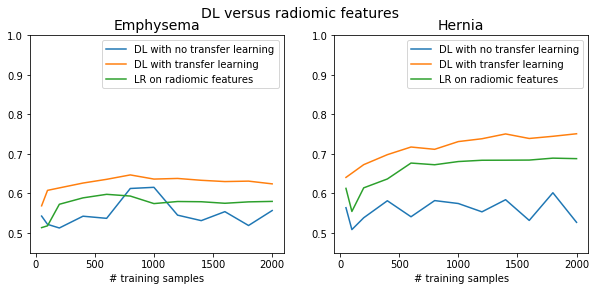

In [231]:
x = [50,100,200,400,600,800,1000,1200,1400,1600,1800,2000]

fig = plt.figure(figsize=(10,4))
fig.suptitle('DL versus radiomic features', fontsize=14)
plt.subplot(1,2,1)
plt.plot(x, no_pretrained_emp, label="DL with no transfer learning")
plt.plot(x, imagenet_emp, label="DL with transfer learning")
plt.plot(x, auc_scores_emp, label="LR on radiomic features")
plt.legend()
plt.ylim(.45,1)
plt.title('Emphysema', fontsize=14)
plt.xlabel("# training samples")


plt.subplot(1,2,2)
plt.plot(x, no_pretrained_hernia, label="DL with no transfer learning")
plt.plot(x, imagenet_hernia, label="DL with transfer learning")
plt.plot(x, auc_scores, label="LR on radiomic features")
plt.legend()
plt.ylim(.45,1)
plt.title('Hernia', fontsize=14)
plt.xlabel("# training samples")

In [232]:
fig.savefig(PATH/'Radiomics_versus_DL.png')

In [233]:
PATH

PosixPath('/data2/yinterian/ChestXray')